### Model Selection
This notebook demonstrates a simple model selection workflow using a variety of sklearn estimators and utility functions. The task is a text classification task where texts are represented as the mean fasttext embedding of the constituent tokens after some minimal preprocessing.

In [1]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import re
import fasttext as ft
import pandas as pd
import numpy as np
import sys

In [2]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [3]:
stopwords = stopwords.words('english')

In [4]:
df = pd.read_csv('res/bbc.csv')

In [5]:
ft_model = ft.load_model('C:/Users/Christian/Desktop/crawl-300d-2M-subword.bin')

In [6]:
def preprocess(text: str) -> list:
    tokens = []
    text = re.sub('[—;/()•,.\[\]\-\'0123456789]', ' ', text)
    for token in text.split():
        token = token.lower()
        if len(token) > 2 and token not in stopwords:
            tokens.append(token)
    
    return tokens

In [7]:
def grid_search(estimator, grid, X, y):
    clf = GridSearchCV(estimator(), grid)
    clf.fit(X, y)
    
    return estimator, clf.best_params_, clf.best_score_

In [8]:
ensembles = [BaggingClassifier, StackingClassifier, VotingClassifier]
func = lambda x: (x[0](**x[1]), x[2])
def train(classifier, X, y, params):
    if classifier in ensembles:
        estimators = [
            (f"c{i}",
                func(
                    grid_search(
                        estimator, 
                        grid, 
                        X, 
                        y
                    )
                )
            ) for i, (estimator, grid) in enumerate(params['estimators'])
        ]
        ensemble_params = {}
        best_estimator = sorted(estimators, key=lambda x: x[1][1], reverse=True)[0][1][0]
        if classifier.__name__ == 'BaggingClassifier':
            estimators = best_estimator
            
        elif classifier.__name__ == 'StackingClassifier':
            ensemble_params.update({'final_estimator': best_estimator})
            estimators = [(estimator[0], estimator[1][0]) for estimator in estimators]
            
        else:
            estimators = [(estimator[0], estimator[1][0]) for estimator in estimators]
            
        clf = classifier(estimators, **ensemble_params)
        clf.fit(X, y)
    
    else:
        clf, best_params, _ = grid_search(classifier, params, X, y)
        clf = clf(**best_params)
        clf.fit(X, y)
        
    return clf

In [13]:
def train_and_predict(classifier, X_train, y_train, X_test, y_test, params):
    clf = train(classifier, X_train, y_train, params)
    pred = clf.predict(X_test)
    
    return (
        accuracy_score(y_test, pred), 
        f1_score(y_test, pred, average='weighted'), 
        pred, 
        clf
    )

In [14]:
X, y = tuple(
    map(
        np.array, 
        list(
            zip(
                *[
                    (
                        np.mean(
                            [ft_model[token] for token in preprocess(x.text)], 
                            axis=0
                        ),
                        x.label
                    ) for x in df.itertuples()
                ]
            )
        )
    )
)

In [77]:
baselines = [
    (
        DummyClassifier, {'strategy': ['uniform']}
    ),
    (
        NearestCentroid, {}
    ),
    (
        KNeighborsClassifier, {'n_neighbors': list(range(5, 25))}
    ),
    (
        DecisionTreeClassifier, {'criterion': ['gini', 'entropy']}
    ),
    (
        LinearSVC, {'C': list(range(1, 10))}
    ),
    (
        CategoricalNB, {'alpha': [0, 0.5, 1]}
    ),
    (
        RadiusNeighborsClassifier, {'radius': [3]}
    ),
    (
        LogisticRegression, {'multi_class': ['ovr']}
    ),
    (
        RandomForestClassifier, {}
    )
]

In [78]:
kf = KFold(n_splits=3, shuffle=True)
models = [
    (ensemble, {'estimators': baselines}) for ensemble in ensembles
] + baselines
results = {model[0].__name__: [] for model in models}
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for model, params in models:
        ret = train_and_predict(model, X_train, y_train, X_test, y_test, params)
        results[model.__name__].append(ret)
        print(f"{model.__name__}: {ret[:2]}\n")
        
    print('---\n')

BaggingClassifier: (0.9625187406296851, 0.9624685235756271)

StackingClassifier: (0.967016491754123, 0.9669514515430262)

VotingClassifier: (0.952023988005997, 0.9520736166966962)

DummyClassifier: (0.2128935532233883, 0.21261130150315952)

NearestCentroid: (0.896551724137931, 0.8986328115358653)

KNeighborsClassifier: (0.9430284857571214, 0.9431313462737215)

DecisionTreeClassifier: (0.863568215892054, 0.8626658725490501)

LinearSVC: (0.9535232383808095, 0.9535631436724877)

CategoricalNB: (0.1889055472263868, 0.06003051437711157)

RadiusNeighborsClassifier: (0.1889055472263868, 0.06003051437711157)

LogisticRegression: (0.8950524737631185, 0.8953352048945538)

RandomForestClassifier: (0.9655172413793104, 0.9655186737800004)

---

BaggingClassifier: (0.9865067466266867, 0.9865025608796322)

StackingClassifier: (0.9850074962518741, 0.9849711982632029)

VotingClassifier: (0.9730134932533733, 0.9730904996443149)

DummyClassifier: (0.21139430284857572, 0.2120290239786933)

NearestCentroid

In [79]:
_, _, _, clf = sorted(sorted(results.items(), key=lambda x: sum([y[0] for y in x[1]]) / len(x[1]), reverse=True)[0][1], key=lambda x: x[0], reverse=True)[0]

In [80]:
clf

StackingClassifier(estimators=[('c0', DummyClassifier(strategy='uniform')),
                               ('c1', NearestCentroid()),
                               ('c2', KNeighborsClassifier(n_neighbors=6)),
                               ('c3',
                                DecisionTreeClassifier(criterion='entropy')),
                               ('c4', LinearSVC(C=9)),
                               ('c5', CategoricalNB(alpha=0)),
                               ('c6', RadiusNeighborsClassifier(radius=3)),
                               ('c7', LogisticRegression(multi_class='ovr')),
                               ('c8', RandomForestClassifier())],
                   final_estimator=RandomForestClassifier())

In [81]:
pred = clf.predict(X)

In [82]:
accuracy_score(y, pred)

0.993

In [83]:
f1_score(y, pred, average='weighted')

0.9929958702328904

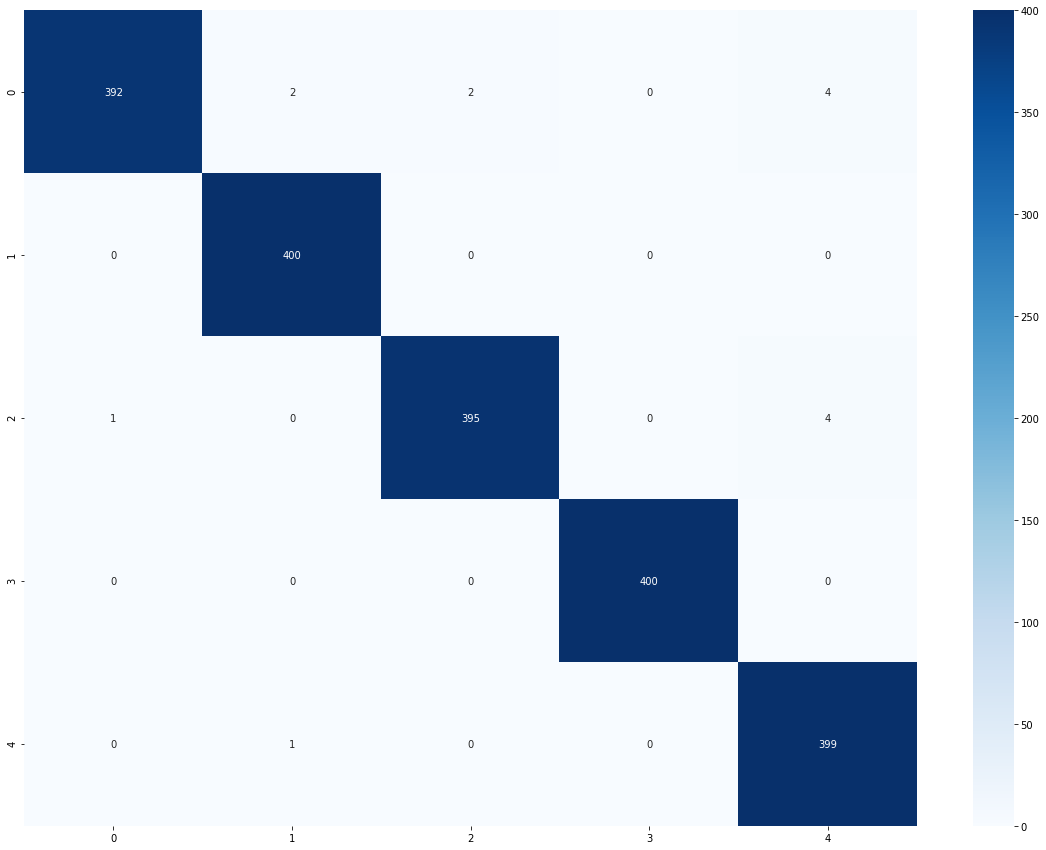

In [84]:
plt.rcParams["figure.figsize"] = (20,15)
sns.heatmap(confusion_matrix(y, pred), annot=True, cmap=plt.cm.Blues, fmt='d')